# CNN to clasiffy Cifar-10

In this notebook, I train a **CNN** to classify images from the CIFAR-10 database.

<img src='notebook_ims/cifar_data.png' width=70% height=70% />

### Test to CUDA

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [1]:
import torch 
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print('CUDA is available! Training on GPU...')
else:
    print('CUDA is not available. Training on CPU...')

CUDA is available! Training on GPU...


# Load and Augmentation data

We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

#### Augmentation

In this cell, we perform some simple [data augmentation](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced) by randomly flipping and rotating the given image data. 

### Datasets and DataLoaders

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 20
valid_size = 0.2

transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                               transforms.RandomRotation(10),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# train and test datasets
trainset = datasets.CIFAR10('data', train = True, download = True, transform = transform)
testset = datasets.CIFAR10('data', train = False, download = True, transform = transform)

# validation indices
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(valid_size * num_train)
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, sampler = train_sampler)
validloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, sampler = valid_sampler)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size)

# classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

print('Train dataset: {} \tValid dataset: {} \tTest dataset: {}'.format(len(train_sampler), len(valid_sampler), len(testset)))

Files already downloaded and verified
Files already downloaded and verified
Train dataset: 40000 	Valid dataset: 10000 	Test dataset: 10000


### Visualization

In [4]:
# Get one batch
images, labels = next(iter(trainloader))
print(images.shape) # (batch_size, channels, W, H)
print(labels.shape)

torch.Size([20, 3, 32, 32])
torch.Size([20])


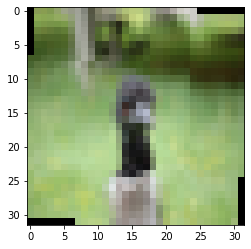

In [5]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
num = 0
imshow(images[num])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

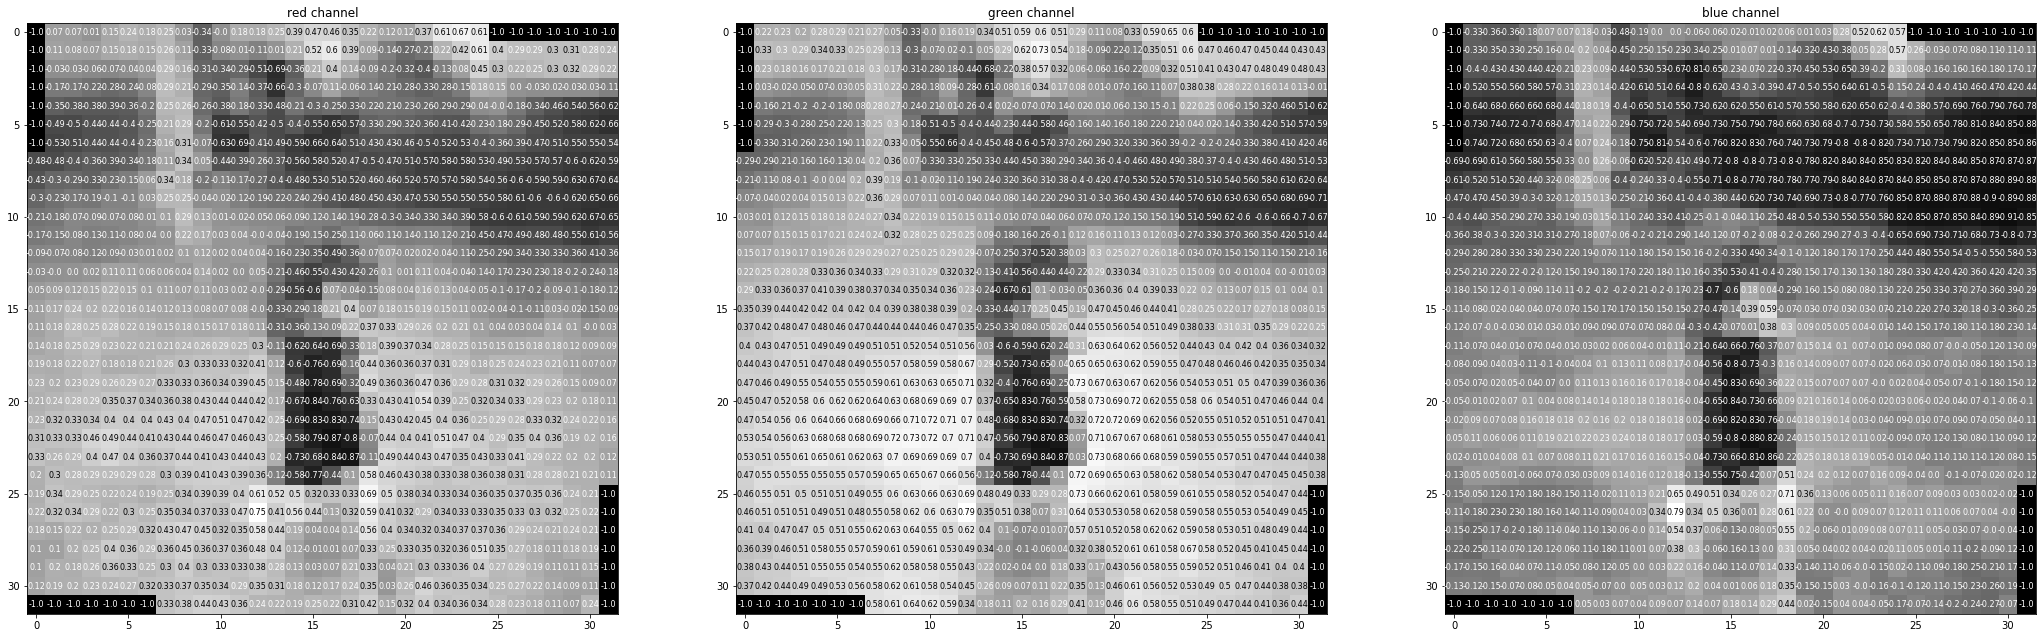

In [6]:
images = images.numpy()
rgb_img = np.squeeze(images[0])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

# Network Architecture

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1) # 32x32x3 * (3x3x3)x16 = 32x32x16 -->maxpooling (2x2) --> 16x16x16
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1) #16x16x16 * (3x3x16)x32 = 16x16x32 -->maxpooling (2x2) --> 8x8x32
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1) #8x8x32 * (3x3x32)x64 = 8x8x64 -->maxpooling (2x2) --> 4x4x64

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(4*4*64, 500)
        self.fc2 = nn.Linear(500, 10)

        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 4*4*64) # (batch_size, 4*4*64)
        
        x = self.dropout(x)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

In [8]:
model = Classifier()
model

Classifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [9]:
if train_on_gpu:
    model.cuda()

# Train and Validation 

In [10]:
from torch import optim

learning_rate = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

In [13]:
start = time.time()

epochs = 25

train_loss_list, valid_loss_list = [], []

valid_loss_min = np.Inf

for epoch in range(epochs):
    
    train_loss = 0
    valid_loss = 0
    
    # Train
    
    model.train()
    for images, labels in trainloader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss_avg = train_loss/len(trainloader)
    train_loss_list.append(train_loss_avg)
    
    # Validation
    model.eval() 
    for images, labels in validloader:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        output = model(images)
        loss = criterion(output, labels)
        valid_loss += loss.item()
    
    valid_loss_avg = valid_loss/len(validloader)
    valid_loss_list.append(valid_loss_avg)

    # prints
    print('Epoch: {}/{} \tTrain loss:{:.3} \tValid loss:{:.3}'.format(epoch+1, epochs,
                                                train_loss_avg, valid_loss_avg))
    
    # save model if validation loss has decreased
    if valid_loss_avg <= valid_loss_min:
        print('Validation loss decreased ({:.3} --> {:.3}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss_avg))
        torch.save(model.state_dict(), 'model_cifar_hla.pt')
        valid_loss_min = valid_loss_avg
        

elapsed_time = float(time.time() - start)
print(elapsed_time)

..\torch\csrc\utils\python_arg_parser.cpp:698: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, Number alpha)


Epoch: 1/25 	Train loss:2.13 	Valid loss:1.86
Validation loss decreased (inf --> 1.86).  Saving model ...
Epoch: 2/25 	Train loss:1.73 	Valid loss:1.54
Validation loss decreased (1.86 --> 1.54).  Saving model ...
Epoch: 3/25 	Train loss:1.54 	Valid loss:1.43
Validation loss decreased (1.54 --> 1.43).  Saving model ...
Epoch: 4/25 	Train loss:1.43 	Valid loss:1.35
Validation loss decreased (1.43 --> 1.35).  Saving model ...
Epoch: 5/25 	Train loss:1.34 	Valid loss:1.23
Validation loss decreased (1.35 --> 1.23).  Saving model ...
Epoch: 6/25 	Train loss:1.27 	Valid loss:1.18
Validation loss decreased (1.23 --> 1.18).  Saving model ...
Epoch: 7/25 	Train loss:1.21 	Valid loss:1.12
Validation loss decreased (1.18 --> 1.12).  Saving model ...
Epoch: 8/25 	Train loss:1.16 	Valid loss:1.07
Validation loss decreased (1.12 --> 1.07).  Saving model ...
Epoch: 9/25 	Train loss:1.11 	Valid loss:1.03
Validation loss decreased (1.07 --> 1.03).  Saving model ...
Epoch: 10/25 	Train loss:1.07 	Valid l

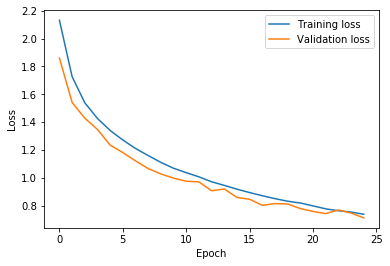

In [20]:
plt.plot(train_loss_list, label = 'Training loss')
plt.plot(valid_loss_list, label = 'Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

###  Load the Model with the Lowest Validation Loss

In [15]:
model.load_state_dict(torch.load('model_cifar_hla.pt'))

<All keys matched successfully>

# Testing 

In [16]:
num = len(classes)
class_correct = list(range(num))
class_total = list(range(num))
test_loss = 0
correct_total = 0

model.eval()
for images, labels in testloader:
    if train_on_gpu:
        images, labels = images.cuda(), labels.cuda()
    output = model(images)
    loss = criterion(output, labels)
    test_loss += loss.item()
    
    _, pred = torch.max(output, 1)
    correct = pred == labels
    correct_total += (pred == labels).sum().item() 
    
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    
accuracy = correct_total / len(testset)

# prints
for i in range(num):
    print('Test accuract of {}: {:.1%}'.format(classes[i], class_correct[i] / class_total[i]))

print('\nTest loss: {:.3} \tGlobal accuracy: {:.1%}'.format(test_loss/len(testloader), accuracy))   

Test accuract of airplane: 76.8%
Test accuract of automobile: 87.2%
Test accuract of bird: 58.7%
Test accuract of cat: 59.0%
Test accuract of deer: 70.5%
Test accuract of dog: 67.2%
Test accuract of frog: 83.1%
Test accuract of horse: 83.4%
Test accuract of ship: 84.0%
Test accuract of truck: 78.2%

Test loss: 0.732 	Global accuracy: 74.7%


### Visualize Sample Test Results

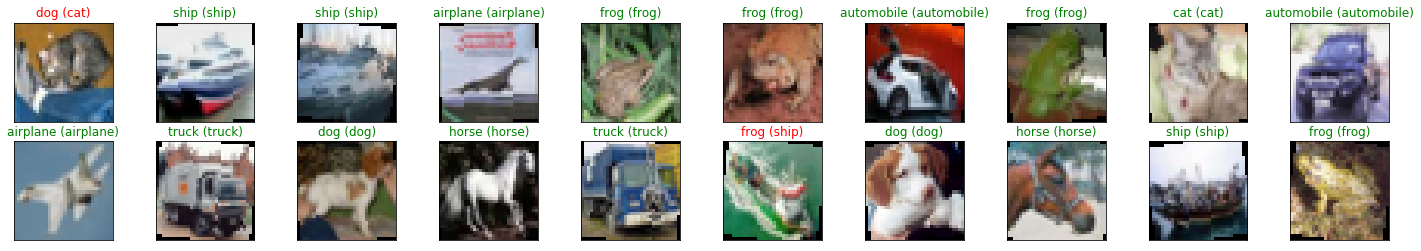

In [17]:
images, labels = next(iter(testloader))
images.numpy()

if train_on_gpu:
    images = images.cuda()

output = model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))